In [1]:
import pandas as pd #data manipulation
from tqdm.auto import tqdm #progress bar
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
import numpy as np #matrix algebra
from lightgbm import LGBMRegressor #LightGBM models
from sklearn.model_selection import train_test_split #ML trainining
from sklearn.metrics import r2_score, mean_squared_error #ML stats
import seaborn as sns #Plotting

ModuleNotFoundError: No module named 'lightgbm'

Enable Pandas progress_apply

In [4]:
tqdm.pandas()

Read the data

In [5]:
df = pd.read_csv("solubility_data_ok.csv")

Set up property calculations

In [6]:
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

Define a function to calculate properties from SMILES

In [7]:
def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        props = np.array(property_getter.ComputeProperties(mol))
    return props

Add the properties to the dataframe

In [8]:
df['props'] = df.SMILES.progress_apply(smi2props)

  0%|          | 0/1818 [00:00<?, ?it/s]

RDKit WARNING: [10:43:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:43:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:43:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:43:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:43:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:43:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:43:17] WARNING: not removing hydrogen atom without neighbors


Split the data into training and test sets

In [9]:
train, test = train_test_split(df)

Define x and y variables for model building

In [10]:
train_X = np.stack(train.props)
train_y = train.Solubility
test_X = np.stack(test.props)
test_y = test.Solubility

Create a LightGBM Regressor

In [11]:
lgbm = LGBMRegressor()

Fit the model

In [12]:
lgbm.fit(train_X, train_y)

LGBMRegressor()

Make the prediction

In [13]:
pred = lgbm.predict(test_X)

Plot predicted vs experimental solubility

<AxesSubplot:xlabel='Solubility'>

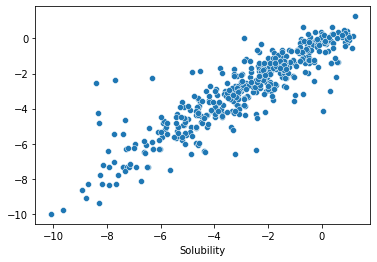

In [14]:
sns.scatterplot(x=test_y,y=pred)

Calculate the coeffcient of determination (R<sup>2</sup>)

In [15]:
r2_score(test_y,pred)

0.8063879605345585

Calculate the RMS error

In [16]:
mean_squared_error(test_y,pred,squared=False)

1.022543645458012